In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import seaborn as sns
import pickle

import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import classification_report

sns.set_context("notebook", font_scale=1.25)
pd.set_option('display.max_colwidth', 128)
pd.set_option('display.max_columns', 500)

In [2]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
mm = mydict['m']

In [5]:
with open('aggrodue.pickle', 'rb') as handle:
    aggrodue = pickle.load(handle)

### regressor

In [6]:
mm.run.max()

9

In [7]:
mm.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [8]:
# minimum number of generated tokens
mm[(mm.segment=='generated')].groupby('pid').tokzero.max().min()

14

In [71]:
# beginning of generation
N = 10

# beginning of generation bears more information (AUC) than end of generation
ds = mm[(mm.segment=='generated') & (mm.tokzero<N)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]

ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

In [72]:
ds

,run,pid,shape0,shape1,shape2,shape3,shape4,shape5,shape6,shape7,shape8,shape9,maxp0,maxp1,maxp2,maxp3,maxp4,maxp5,maxp6,maxp7,maxp8,maxp9,true_ent0,true_ent1,true_ent2,true_ent3,true_ent4,true_ent5,true_ent6,true_ent7,true_ent8,true_ent9,correct,hallucinated
0,0,9,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,1.0,1.0,1.000000,0.992606,1.000000,0.518202,1.000000,1.000000,0.999985,0.573826,0.999996,0.999969,7.224133e-06,0.058420,5.036472e-06,7.166480e-01,1.664804e-08,5.324713e-07,2.034433e-04,1.525819e+00,6.502650e-05,4.334208e-04,False,False
1,0,10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.998764,0.999864,0.940220,1.000000,1.000000,0.999989,0.987074,0.999998,0.999959,1.616158e-06,0.012218,1.506806e-03,2.517824e-01,8.579906e-09,8.837126e-07,1.639340e-04,9.334140e-02,2.433762e-05,5.074464e-04,False,False
2,0,12,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.000000,0.997829,1.000000,0.999999,0.999999,0.996164,0.707576,1.000000,1.000000,0.999991,9.756351e-07,0.017998,5.711260e-07,1.362268e-05,1.221164e-05,2.904172e-02,6.464605e-01,2.070488e-08,1.401210e-06,1.227201e-04,False,False
3,0,14,1.0,1.0,1.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.000000,0.994415,0.999967,0.561076,1.000000,1.000000,0.768818,1.000000,1.000000,0.999991,2.472243e-06,0.035839,4.299130e-04,1.115004e+00,9.973774e-07,2.550019e-06,5.443041e-01,3.232657e-08,3.176602e-07,1.276724e-04,False,False
4,0,17,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999999,0.842796,0.557818,1.000000,0.999991,0.999093,1.000000,1.000000,0.999991,0.999996,1.480168e-05,0.637194,6.945014e-01,2.445166e-06,1.360828e-04,8.025359e-03,8.336202e-09,5.174461e-07,1.205831e-04,5.824901e-05,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6875,9,1788,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.999735,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,0.996888,0.999999,7.603943e-07,0.002725,9.010122e-06,1.137201e-05,3.049808e-06,2.346361e-07,1.727000e-08,1.542884e-06,2.139582e-02,1.466352e-05,True,False
6876,9,1789,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.998938,1.000000,1.000000,0.999998,0.966994,1.000000,1.000000,0.999837,0.975813,7.446607e-07,0.008928,6.993531e-08,1.876450e-06,2.689730e-05,1.488801e-01,1.133345e-08,9.309534e-07,1.654437e-03,1.154494e-01,True,False
6877,9,1790,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.999904,0.999928,1.000000,0.996329,1.000000,0.999998,1.000000,1.000000,1.000000,5.459514e-06,0.001212,7.720306e-04,1.245706e-06,2.812353e-02,3.760191e-06,3.647040e-05,8.510714e-06,1.821284e-07,9.020661e-09,False,False
6878,9,1794,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.984611,1.000000,1.000000,0.999913,0.983362,1.000000,1.000000,0.999995,1.000000,6.141302e-06,0.091519,2.436548e-07,4.925757e-07,9.596071e-04,1.008549e-01,7.226087e-08,3.133798e-06,7.783296e-05,2.372521e-06,True,False


In [73]:
ds = ds.merge(aggrodue[['pid', 'answers_entropy_norm', 'correct_mean']], on='pid')

In [74]:
ds.correct.value_counts()

correct
True     4779
False    1881
Name: count, dtype: int64

In [75]:
# WARNING here we are dropping duplicates (include correct as variable)
ds = ds.drop_duplicates(ds.columns[1:-3])

In [76]:
ds

,run,pid,shape0,shape1,shape2,shape3,shape4,shape5,shape6,shape7,shape8,shape9,maxp0,maxp1,maxp2,maxp3,maxp4,maxp5,maxp6,maxp7,maxp8,maxp9,true_ent0,true_ent1,true_ent2,true_ent3,true_ent4,true_ent5,true_ent6,true_ent7,true_ent8,true_ent9,correct,hallucinated,answers_entropy_norm,correct_mean
0,0,9,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,0.992606,1.000000,0.518202,1.000000,1.000000,0.999985,0.573826,0.999996,0.999969,7.224133e-06,0.058420,5.036472e-06,7.166480e-01,1.664804e-08,5.324713e-07,2.034433e-04,1.525819e+00,6.502650e-05,4.334208e-04,False,False,0.547371,0.666667
1,1,9,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,0.992606,1.000000,0.518202,1.000000,1.000000,0.999985,0.573826,1.000000,0.999998,7.224133e-06,0.058420,5.036472e-06,7.166480e-01,1.664804e-08,5.324713e-07,2.034433e-04,1.525819e+00,1.963413e-06,2.542405e-05,False,False,0.547371,0.666667
3,3,9,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.992606,1.000000,0.518202,0.999998,1.000000,1.000000,0.999337,0.996735,1.000000,7.224133e-06,0.058420,5.036472e-06,7.166480e-01,3.900399e-05,3.894976e-08,1.299983e-06,5.816230e-03,2.363233e-02,9.276389e-07,True,False,0.547371,0.666667
7,7,9,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,0.992606,1.000000,0.518202,1.000000,1.000000,0.999985,0.573826,1.000000,1.000000,7.224133e-06,0.058420,5.036472e-06,7.166480e-01,1.664804e-08,5.324713e-07,2.034433e-04,1.525819e+00,1.103188e-05,2.230653e-06,False,False,0.547371,0.666667
10,0,10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.998764,0.999864,0.940220,1.000000,1.000000,0.999989,0.987074,0.999998,0.999959,1.616158e-06,0.012218,1.506806e-03,2.517824e-01,8.579906e-09,8.837126e-07,1.639340e-04,9.334140e-02,2.433762e-05,5.074464e-04,False,False,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6620,0,1789,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.998938,1.000000,1.000000,0.999998,0.966994,1.000000,1.000000,0.999837,0.975813,7.446607e-07,0.008928,6.993531e-08,1.876450e-06,2.689730e-05,1.488801e-01,1.133345e-08,9.309534e-07,1.654437e-03,1.154494e-01,True,False,0.000000,1.000000
6630,0,1790,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999904,0.999928,1.000000,0.996329,1.000000,0.999998,1.000000,1.000000,1.000000,5.459514e-06,0.001212,7.720306e-04,1.245706e-06,2.812353e-02,3.760191e-06,3.647040e-05,8.510714e-06,1.821284e-07,9.020661e-09,False,False,0.000000,0.000000
6640,0,1794,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.984611,1.000000,1.000000,0.999913,0.983362,1.000000,1.000000,0.999995,1.000000,6.141302e-06,0.091519,2.436548e-07,4.925757e-07,9.596071e-04,1.008549e-01,7.226087e-08,3.133798e-06,7.783296e-05,2.372521e-06,True,False,0.000000,1.000000
6650,0,1797,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.999925,0.999996,1.000000,1.000000,1.000000,1.000000,0.827240,0.999999,1.000000,3.463509e-07,0.000818,5.827549e-05,3.070424e-07,1.018147e-07,2.408649e-09,1.065855e-06,5.202428e-01,1.655960e-05,1.533124e-07,True,False,0.000000,1.000000


In [77]:
y = ds.answers_entropy_norm
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', 'answers_entropy_norm', 'correct_mean'])

In [78]:
X.loc[:,X.nunique()!=1].shape

(1043, 30)

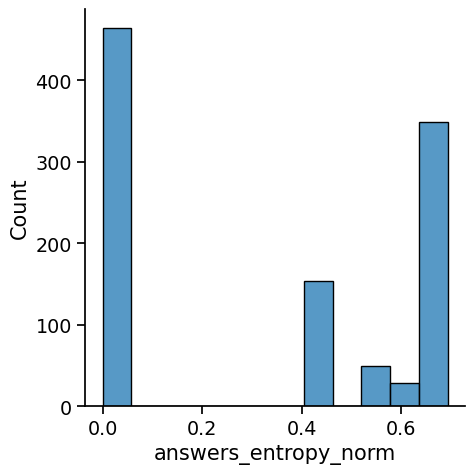

In [79]:
sns.displot(y)

In [80]:
X.isnull().sum().sum() == 0

True

In [81]:
# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_generated = y_res

X_res.columns = ['generated_'+col for col in X.columns]

In [82]:
X_res.isnull().sum().sum() == 0

True

### beginning of generation

In [83]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 6.44 s, sys: 315 ms, total: 6.76 s
Wall time: 886 ms


In [113]:
pred

array([0.5890056 , 0.5890056 , 0.12156724, ..., 0.12356793, 0.52903795,
       0.52903795], dtype=float32)

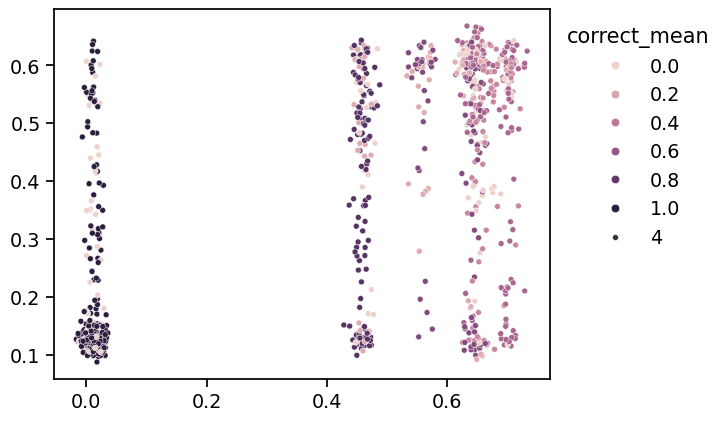

In [129]:
def jitter(values,j):
    return values + np.random.normal(j,0.01,values.shape)

ax = sns.scatterplot(y=jitter(pred,0.01), x=jitter(y_res.values, 0.01), hue=correct_mean, size=4)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()

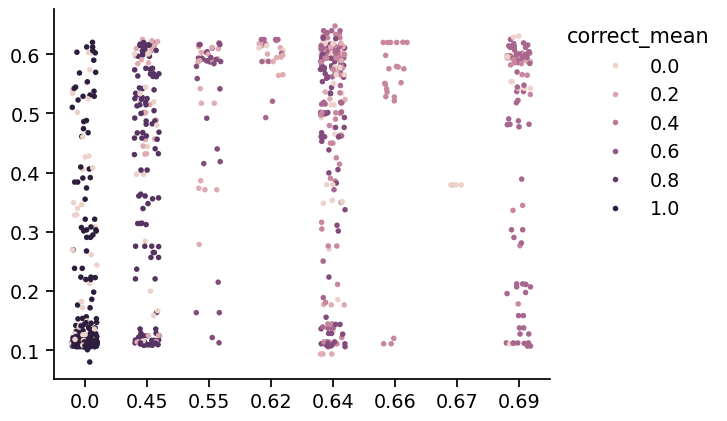

In [116]:
ax = sns.stripplot(y=pred, x=np.round(y_res.values,2), jitter=0.2, hue=correct_mean, size=4) # , log_scale=(True,False))
sns.despine()

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()

In [90]:
# TODO absolute measures

11

In [136]:
pred = pred_proba.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.69      0.67      0.68       429
        True       0.77      0.79      0.78       593

    accuracy                           0.74      1022
   macro avg       0.73      0.73      0.73      1022
weighted avg       0.73      0.74      0.74      1022



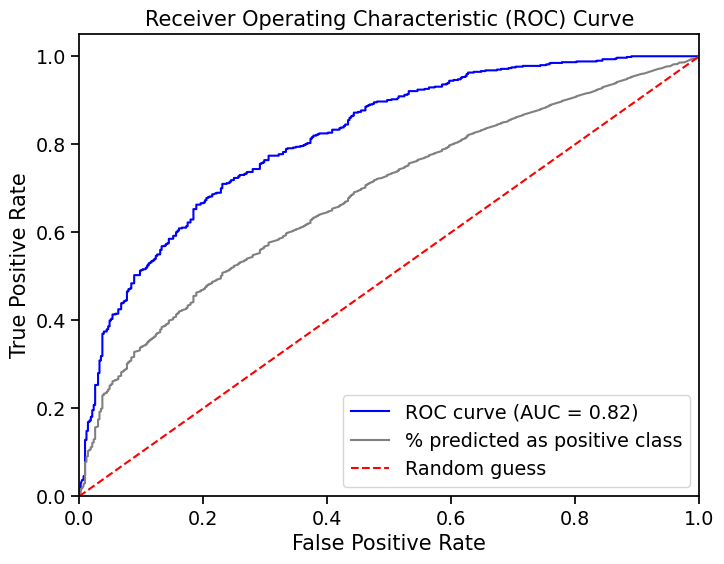

In [137]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / len(y_res.values) for thr in thresholds]

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='grey', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [131]:
import xgboost
import shap

model = xgboost.XGBRegressor(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

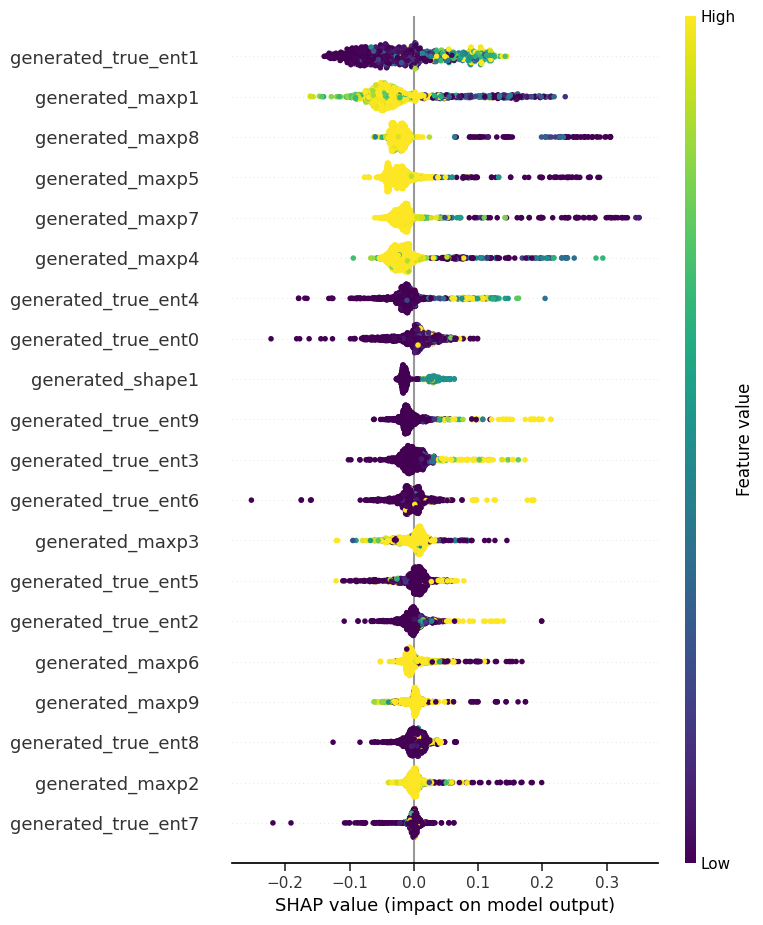

In [132]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [133]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [134]:
vals.groupby('grp').value.sum()

grp
generated_maxp        0.501533
generated_shape       0.071002
generated_true_ent    0.427465
Name: value, dtype: float64

In [135]:
K = 10
top_feat_generated_begin = vals.sort_values('value', ascending=False)[:K].label_orig.tolist()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

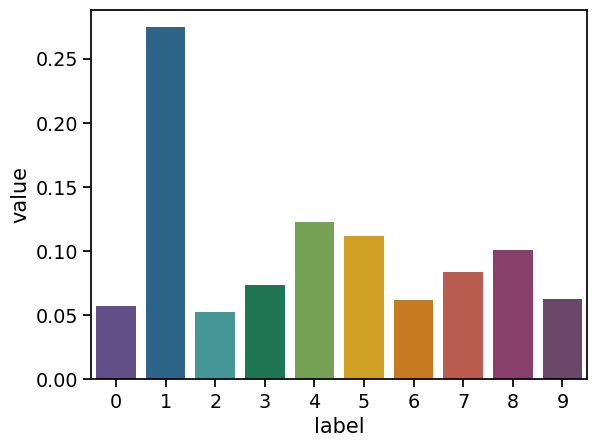

In [136]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

Text(27.44444444444443, 0.5, 'Token index')

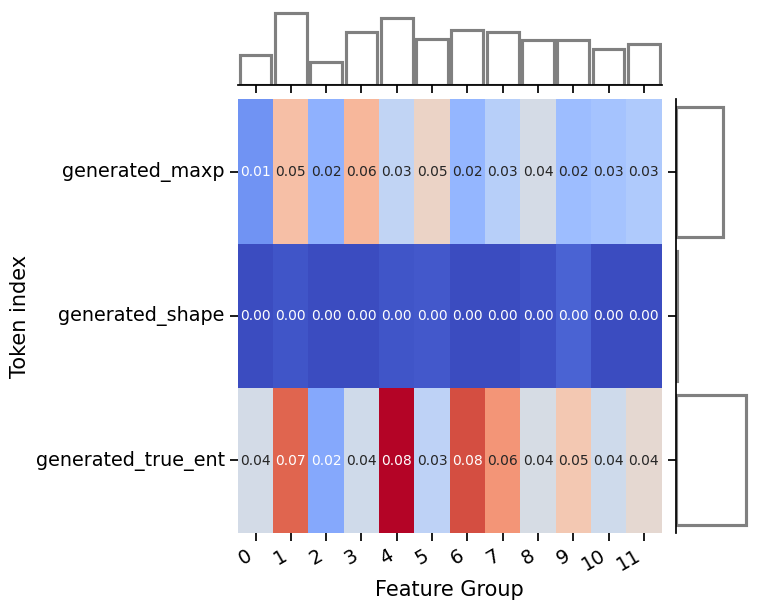

In [59]:
_toplot = vals.pivot(index='grp', columns='label', values='value')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')
# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### postilla

In [138]:
# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

# WARNING here we are dropping duplicates (include correct as variable)
ds = ds.merge(aggrodue[['pid', 'answers_entropy_norm', 'correct_mean']], on='pid')
ds = ds.drop_duplicates(ds.columns[1:-3])

y = ds.answers_entropy_norm
correct_mean = ds.correct_mean
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated', 'answers_entropy_norm', 'correct_mean'])

# rus = RandomUnderSampler(random_state=42)
X_res, y_res = X, y # rus.fit_resample(X, y)
pids_res = pids # [y_res.index]

y_res_postilla = y_res
X_res.columns = ['postilla_'+col for col in X.columns]

In [140]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost


xgb_model = XGBRFRegressor(n_estimators=100, n_jobs=6)

pred_postilla = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res)

CPU times: user 30.8 s, sys: 1.3 s, total: 32.1 s
Wall time: 4.83 s


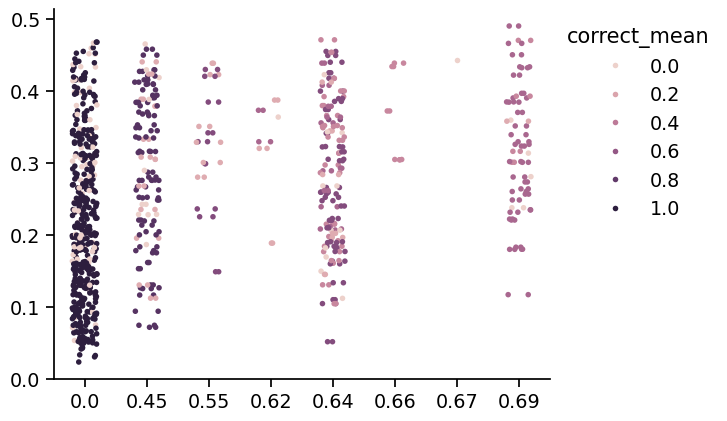

In [141]:
ax = sns.stripplot(y=pred_postilla, x=np.round(y_res_postilla.values,2), jitter=0.2, hue=correct_mean, size=4) # , log_scale=(True,False))
sns.despine()

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.show()